# Gaussian-Linear Hidden Markov Model

This notebook shows an example of training and inspecting a Gaussian-Linear Hidden Markov Model (GLHMM). This model is fit to two sets of timeseries, such as a neuroimaging/electrophysiological recording and a corresponding behavioural or other physiological timeseries. If you want to model just one set of timeseries, you can e.g., use the [*Standard Gaussian HMM*](./GaussianHMM_example.ipynb). If you are new to the HMM or the GLHMM toolbox, we recommend starting there for a thorough introduction.

Authors: Christine Ahrends <christine.ahrends@cfin.au.dk>

## Outline
1. [Background](#background)
2. [Example: Modelling time-varying interaction between brain and physiological data](#example-modelling)
    * [Preparation](#preparation)
    * [Load data](#load-data)
    * [Initialise and train a GLHMM](#initialise-glhmm)
    * [Inspect model](#inspect-model)
        * [Interaction between brain and physiological measures](#interaction)
        * [State means and covariances](#state-means-covariances)
        * [Dynamics: Transition probabilities and Viterbi path](#dynamics)

## Background <a id="background"></a>
The GLHMM is a generalization of the HMM, introduced in [Vidaurre et al., 2023](https://arxiv.org/abs/2312.07151). 
We here assume that the observations *Y* at time point *t* were generated by a Gaussian distribution with parameters $\mu$ and $\Sigma$ (similar to the standard Gaussian HMM), as well as regression coefficients $\beta$ that relate the second set of variables *X* to *Y*. When state *k* is active at time point *t*, the GLHMM thus assumes that the timeseries *Y* follows the following distribution:
$$Y_t\sim N(\mu^k+X_t\beta^k,\Sigma^k)$$
Compared to the standard Gaussian HMM, the GLHMM thus adds the $X_t\beta^k$ term, which allows modelling the relationship to a second set of variables.

The remaining HMM parameters are essentially the same as in the standard HMM, i.e. the transition probabilities $\theta$:
$$P(s_t=k|s_{t-1}=l)=\theta_{k,l}$$
the initial state probabilities $\pi$:
$$P(s_t=k)=\pi_k$$
as well as the posterior estimates for both X and Y:
$$\gamma_{t,k}:=P(s_t=k|s_{>t},s_{<t},X,Y)$$
$$\xi_{t,k,l}:=P(s_t=k,s_{t-1}=l|s_{>t},s_{<t-1},X,Y)$$

The GLHMM can be used to model, in addition to the patterns described by the standard HMM (such as time-varying amplitude or functional connectivity), temporal changes in the relationship between two timeseries. This could be, for instance, the interaction between one group of brain areas in the prefrontal cortex and another group of brain areas in the occipital cortex, the relationship between BOLD-signal across the whole brain and respiration, or the interaction between EEG recordings from two participants recorded simultaneously. 

## Example: Modelling time-varying interaction between brain and physiological data <a id="example-modelling"></a>
We will now go through an example illustrating how to fit and inspect a GLHMM. The example uses simulated data that can be found in the `example_data` folder. The data were generated to resemble one set of fMRI timeseries and two corresponding non-brain physiological (e.g., heart rate and respiration) timeseries. Our goal is to estimate time-varying amplitude and functional connectivity (FC) within the fMRI recordings and temporal changes in the relationship between the fMRI and the physiological data. 

### Preparation <a id="preparation"></a>
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install glhmm```

We then need to import the relevant modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from glhmm import glhmm, preproc, utils, graphics

### Load and prepare data <a id="load-data"></a>
The GLHMM requires two inputs: a timeseries `Y`and a second timeseries `X`. When running the model on a concatenated timeseries, e.g., a group of subjects or several scanning sessions, you also need to provide the `indices` indicating where each subject/session in the concatenated timeseries `Y` starts and ends. Loading data and data formats are explained in more detail in the [Standard Gaussian HMM tutorial](./GaussianHMM_example.ipynb).

Synthetic data for this example are provided in the `glhmm/docs/notebooks/example_data` folder. The file `data.csv` contains synthetic data for the first set of timeseries `Y`. This is the brain data, containing fMRI recordings from 20 subjects with 1,000 timepoints each, concatenated along the first dimension, and 50 brain areas. The file `dataX.csv` contains the corresponding physiological measures, heart rate and respiration. The sessions have the same duration as the brain data, i.e., there are 20 concatenated subjects with 1,000 timepoints each, but only 2 variables (heart rate and respiration). The file `T.csv` specifies the beginning and end of each subject's session (same for `X` and `Y`). 

In [2]:
brain_data = pd.read_csv('./example_data/data.csv', header=None).to_numpy()
phys_data = pd.read_csv('./example_data/dataX.csv', header=None).to_numpy()
T_t = pd.read_csv('./example_data/T.csv', header=None).to_numpy()

**NOTE: It is important to standardise your timeseries and, if necessary, apply other kinds of preprocessing before fitting the model.**\
This will be done separately for each session/subject as specified in the indices. The data provided here are already close to standardised (so the code below will not do much), but see [Prediction tutorial](./Prediction_example.ipynb) to see the effect on real data. 

In [3]:
brain_data,_ = preproc.preprocess_data(brain_data, T_t)
phys_data,_ = preproc.preprocess_data(phys_data, T_t)

### Initialise and train a GLHMM <a id="initialise-glhmm"></a>
We first initialise the glhmm object, which we here call `brainphys_glhmm`. By specifying the parameters of the glhmm object, we define which type of model we want to fit and how states should be defined. In the case of the GLHMM, we need to set the `model_beta` parameter to indicate that we wish to model an interaction between two sets of variables. There are two options for modelling the interaction: global, meaning we estimate regression coefficients that are static over the timeseries in which case `model_beta='shared'`, or state-dependent, meaning we estimate regression coefficients that vary over time in which case `model_beta='state'`. In this example, we want to model the time-varying interaction between the brain data and the physiological data, so we set `model_beta='state'`. For the other parameters, we here want to use the same set-up as in the [standard Gaussian HMM](./GaussianHMM_example.ipynb), i.e., each state will be defined in terms of mean and covariance. That means, we will also estimate the time-varying amplitude and functional connectivity in the brain timeseries. We model 4 states by setting the parameter `K=4`, which you can compare to the states from the standard Gaussian HMM.

In [4]:
brainphys_glhmm = glhmm.glhmm(model_beta='state', K=4, covtype='full')

We can check the hyperparameters of the object to make sure the model is defined as we planned:

In [5]:
print(brainphys_glhmm.hyperparameters)

{'K': 4, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'state', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]]), 'Pistructure': array([ True,  True,  True,  True])}


We then train the model. To model the interaction, we need to train the GLHMM using both the brain data and the physiological data. The "main" timeseries we are looking to model, i.e., the data for which we also want to estimate mean and covariance, is `Y`, so in this case `Y=brain_data`. The secondary timeseries from which we model only the interaction with the main timeseries is called `X` so `X=phys_data`. When fitting the model to a group of subjects or sessions, we also need to specify the indices of the start and end of each session (here called `T_t`). Note that the indices are shared for `X` and `Y`, so the beginning and end of the sessions in `X` and `Y` need to correspond. During training, the output will usually show the progress in model fit at each iteration. This can be quite long, so we have here suppressed it for displaying purposes. You can remove the first line (`%%capture`) to show it.

In [8]:
%%capture
brainphys_glhmm.train(X=phys_data, Y=brain_data, indices=T_t)

### Inspect model <a id="inspect-model"></a>

#### Interaction between brain and physiological measures <a id="interaction"></a>
Let's start by retrieving the parameters describing the interaction, i.e., the $\beta$ values, between the two sets of timeseries: the brain data and the physiological data (heart rate & respiration). The beta-values can be obtained from the trained model using the `get_betas()` function (or alternatively `get_beta(k)` to obtain only the beta-values for state `k`):

In [9]:
K = brainphys_glhmm.hyperparameters["K"] # the number of states
q = brain_data.shape[1] # the number of parcels/channels
state_betas = np.zeros(shape=(2,q,K))
state_betas = brainphys_glhmm.get_betas()

Since we here defined $\beta$ to be time-varying, i.e., state-dependent, we have a matrix describing the interaction between each of the 50 brain regions and the 2 physiological measures for each of the 4 states:

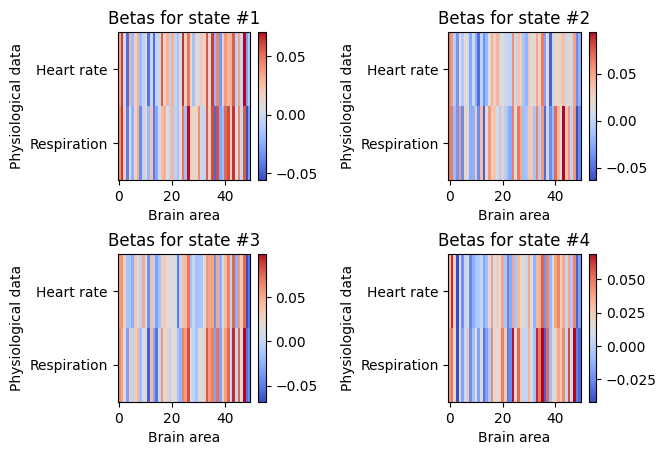

In [10]:
cmap = "coolwarm"
ytick =["Heart rate", "Respiration"]
for k in range(K):
    plt.subplot(2,2,k+1)
    plt.imshow(state_betas[:,:,k], cmap=cmap,aspect='auto', interpolation='none')
    plt.colorbar()
    plt.ylabel('Physiological data')
    plt.yticks(np.arange(2), ytick)
    plt.xlabel('Brain area')
    plt.title(f"Betas for state #{k+1}")
plt.subplots_adjust(hspace=0.5, wspace=1)
plt.show()

#### State means and covariances <a id="state-means-covariances"></a>
We have defined the model so that each state also has a mean (amplitude) and covariance (functional connectivity), as in the [Standard Gaussian HMM](./GaussianHMM_example.ipynb). We can retrieve them by using the `get_mean` and `get_covariance_matrix` functions:

In [11]:
state_means = np.zeros(shape=(q, K))
for k in range(K):
    state_means[:,k] = brainphys_glhmm.get_mean(k) # the state means in the shape (no. features, no. states)
state_FC = np.zeros(shape=(q, q, K))
for k in range(K):
    state_FC[:,:,k] = brainphys_glhmm.get_covariance_matrix(k=k) # the state covariance matrices in the shape (no. features, no. features, no. states)

And plot them:

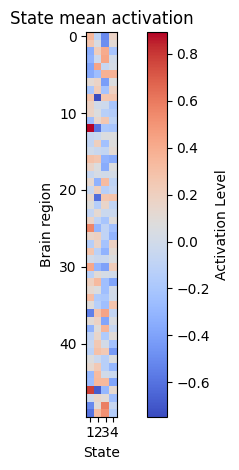

In [12]:
plt.imshow(state_means,cmap=cmap, interpolation="none")
plt.colorbar(label='Activation Level') # Label for color bar
plt.title("State mean activation")
plt.xticks(np.arange(K), np.arange(1,K+1))
plt.gca().set_xlabel('State')
plt.gca().set_ylabel('Brain region')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

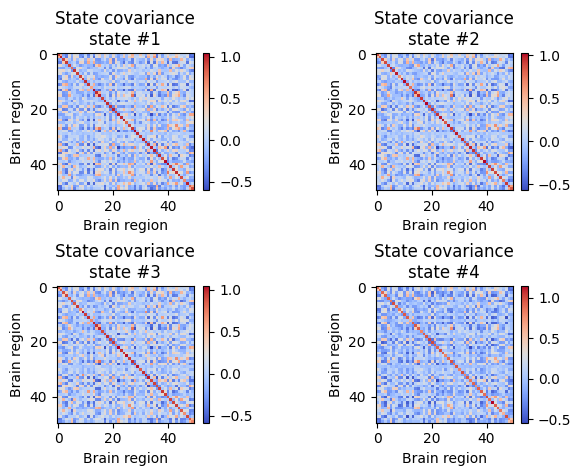

In [13]:
for k in range(K):
    plt.subplot(2,2,k+1)
    plt.imshow(state_FC[:,:,k], cmap=cmap, interpolation="none")
    plt.xlabel('Brain region')
    plt.ylabel('Brain region')
    plt.colorbar()
    plt.title("State covariance\nstate #%s" % (k+1))
plt.subplots_adjust(hspace=0.7, wspace=0.8)
plt.show()

#### Dynamics: Transition probabilities and Viterbi path <a id="dynamics"></a>
We can also look at the transition probabilities and the Viterbi path to understand the temporal sequence in which the states occur. See [Standard Gaussian HMM](./GaussianHMM_example.ipynb) for a detailed explanation. The transition probabilities with and without self-transitions:

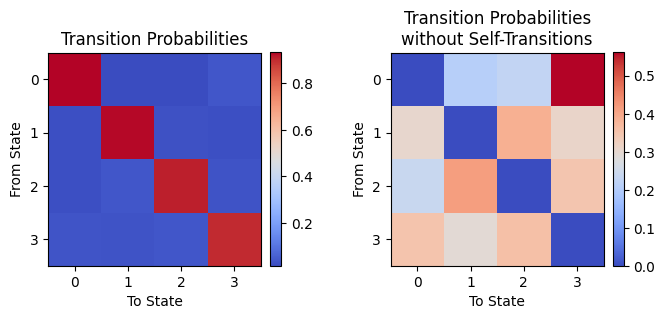

In [14]:
TP = brainphys_glhmm.P.copy() # the transition probability matrix

# Plot Transition Probabilities
plt.figure(figsize=(7, 4))

# Plot 1: Full Transition Probabilities
plt.subplot(1, 2, 1)
plt.imshow(TP, cmap=cmap, interpolation='nearest')  # Improved color mapping
plt.title('Transition Probabilities')
plt.xlabel('To State')
plt.ylabel('From State')
plt.colorbar(fraction=0.046, pad=0.04)

# Plot 2: Transition Probabilities without Self-Transitions
TP_noself = TP - np.diag(np.diag(TP))  # Remove self-transitions
TP_noself2 = TP_noself / TP_noself.sum(axis=1, keepdims=True)  # Normalize probabilities
plt.subplot(1, 2, 2)
plt.imshow(TP_noself2, cmap=cmap, interpolation='nearest')  # Improved color mapping
plt.title('Transition Probabilities\nwithout Self-Transitions')
plt.xlabel('To State')
plt.ylabel('From State')
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


And the Viterbi path:

In [15]:
vpath = brainphys_glhmm.decode(X=phys_data, Y=brain_data, indices=T_t, viterbi=True)

And plot the Viterbi path (see also `graphics` module):

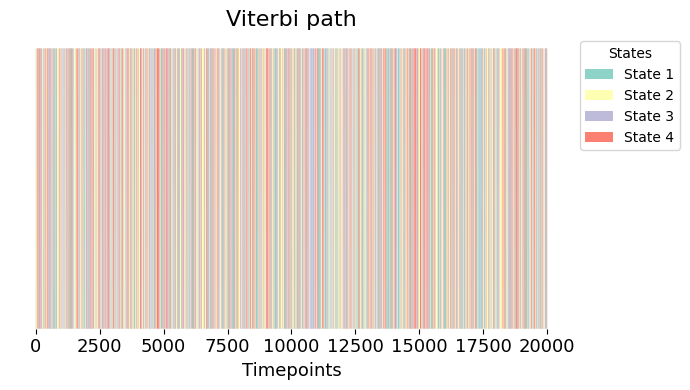

In [16]:
graphics.plot_vpath(vpath, title="Viterbi path")

As an example, let's have a look at the first 1000 timepoints from one subject to get a feeling for the rate at which states switch over the scanning session. 

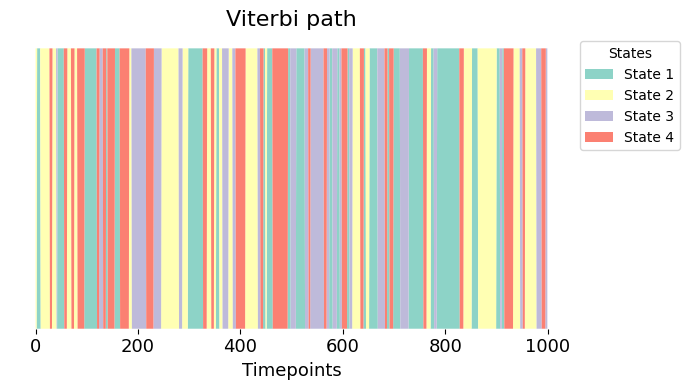

In [17]:
num_subject = 0
graphics.plot_vpath(vpath[T_t[num_subject,0]:T_t[num_subject,1],:], title="Viterbi path")

As for the standard HMM, there is a range of useful summary metrics that you can compute to describe the obtained patterns. Have a look at the [Standard Gaussian HMM tutorial](./GaussianHMM_example.ipynb) to see how to obtain them from your trained model. These can be used, e.g., for statistical testing (see [Statistical testing tutorial](./Testing_across_subjects.ipynb)) or prediction/machine learning (see [Prediction tutorial](./Prediction_example.ipynb)). 